# Определение возраста покупателей

**Описание проекта:**

   Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

**Задача:**
* Построить модель, которая по фотографии определит приблизительный возраст человека. Для обучения используется набор фотографий людей с указанием возраста.

**План:**
* Провести исследовательский анализ набора фотографий.
* Подготовить данные к обучению.
* Обучить нейронную сеть на GPU и рассчитать её качество.
* Провести анализ обученой модели и сделать вывод.

## Исследовательский анализ данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from PIL import Image
import seaborn as sns

In [ ]:
labels_df = pd.read_csv('/datasets/faces/labels.csv')
labels_df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
missing_values = labels_df.isnull().sum()
missing_values

file_name    0
real_age     0
dtype: int64

In [ ]:
num_samples = len(labels_df)
f"Размер выборки: {num_samples} изображений"

'Размер выборки: 7591 изображений'

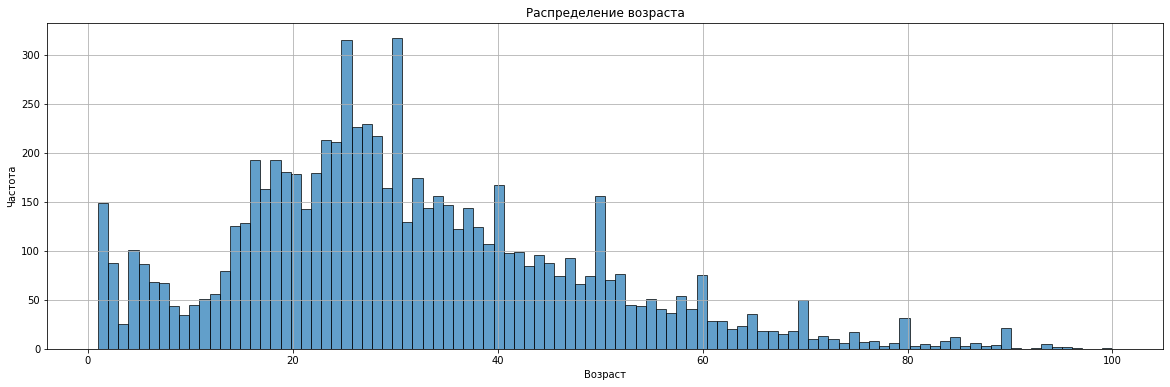

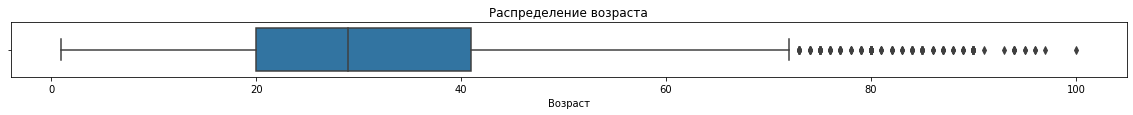

In [ ]:
plt.figure(figsize=(20, 6))
plt.hist(labels_df['real_age'], bins=100, edgecolor='k', alpha=0.7)
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 1))
sns.boxplot(x=labels_df['real_age'])
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.show()

Больше всего фотографий с людьми в возрасте от 20 до 30 лет. График имеет нормальное распределение, однако наблюдается пик в возрастной категории от 0 до примерно 3х лет.

In [ ]:
def display_images(dataframe, directory, num_images=15, images_per_row=5):
    num_rows = (num_images // images_per_row) + (num_images % images_per_row > 0)
    plt.figure(figsize=(20, num_rows * 4))
    sample_images = dataframe.sample(num_images)
    for i, (index, row) in enumerate(sample_images.iterrows()):
        img_path = os.path.join(directory, row['file_name'])
        img = Image.open(img_path)
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Age: {row['real_age']}")
    plt.tight_layout()
    plt.show()

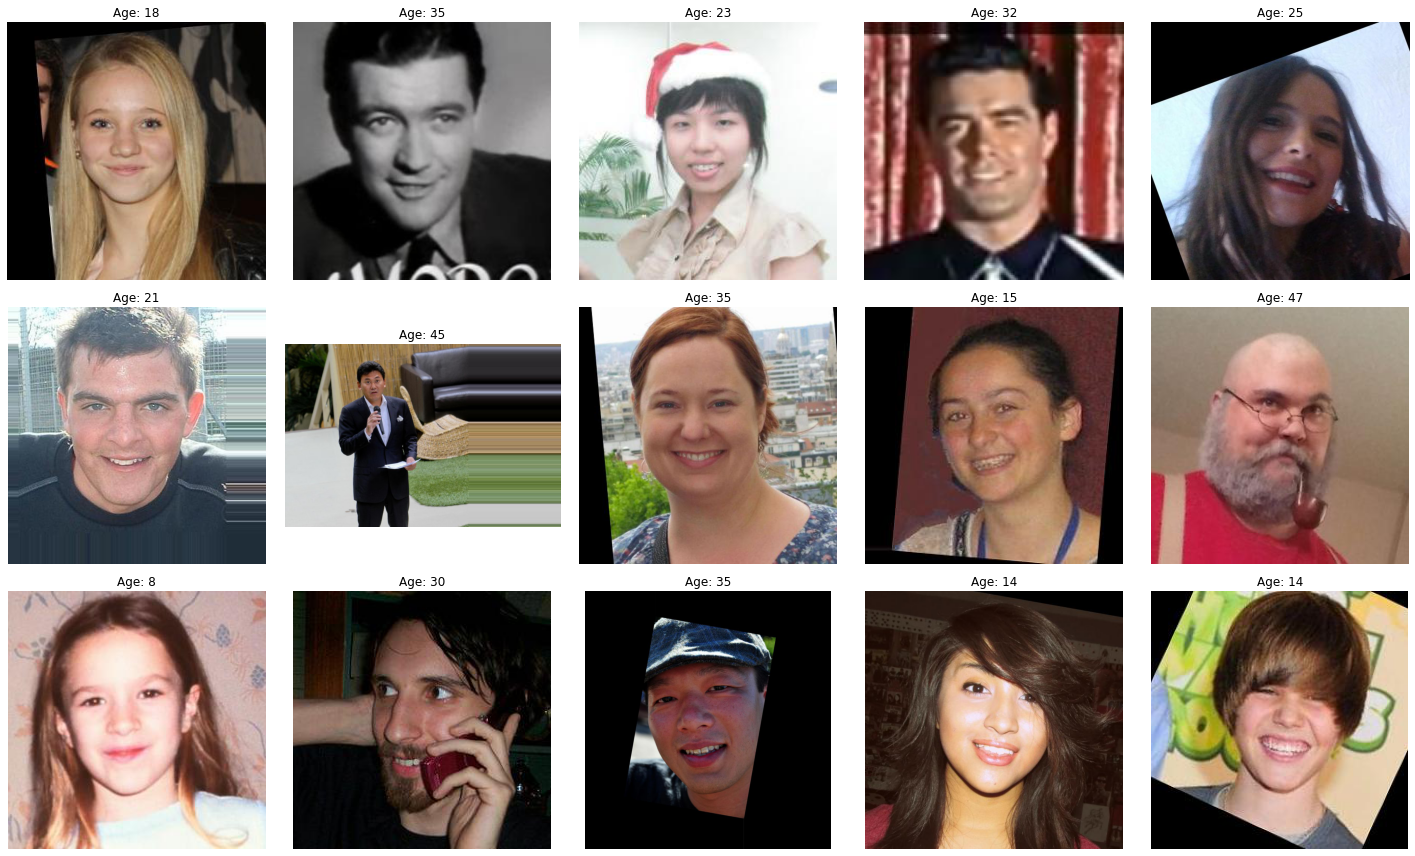

In [ ]:
image_directory = '/datasets/faces/final_files'
display_images(labels_df, image_directory, num_images=15)

* В датафрейме содержатся различные фотографии: как цветные, так и черно-белые, а также изображения разного качества — от хорошего до плохого. В основном лица на фотографиях расположены вертикально.

* Подготовка данных для обучения модели включает в себя приведение изображений к единому формату, улучшение качества, аугментацию, разделение на обучающую и тестовую выборки, организацию и очистку данных. Эти шаги помогут создать качественный и однородный набор данных, который будет способствовать эффективному обучению модели.

Далее в коде представлены следующие этапы для подготовки данных:

1. Нормализация: Значения пикселей изображений масштабируются в диапазон [0, 1] с помощью параметра rescale=1. / 255.

2. Аугментация данных: Частично реализована через горизонтальное отражение. Это помогает улучшить устойчивость модели к различным ориентациям изображений, так же используются случайные повороты и масштабирование.

3. Разделение на обучающую и валидационную выборку.

4. Создание генераторов данных: Это позволяет организовать данные для подачи в модель, обеспечивая их потоковый ввод и предварительную обработку в реальном времени.

## Обучение модели

```python
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    data = pd.read_csv(path + 'labels.csv')
    generator = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.25,
        rotation_range=10,
        zoom_range=0.2,
        horizontal_flip=True
    )

    train_data = generator.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        subset='training',
        seed=42
    )
    return train_data


def load_test(path):
    data = pd.read_csv(path + 'labels.csv')
    generator = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.25
    )

    validation_data = generator.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        subset='validation',
        seed=42
    )
    return validation_data

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)
    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(1, activation='relu')
    ])
    model.compile(optimizer=Adam(lr=0.0001), loss='mse', metrics=['mae'])
    
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    steps_per_epoch = steps_per_epoch or len(train_data)
    validation_steps = validation_steps or len(test_data)
    
    model.fit(train_data, validation_data=test_data, batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=2)
    
    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/10
2024-08-22 09:48:00.151808: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-08-22 09:48:01.792807: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 79s - loss: 238.5534 - mae: 11.0462 - val_loss: 809.7112 - val_mae: 23.4285
Epoch 2/10
178/178 - 46s - loss: 74.5002 - mae: 6.4896 - val_loss: 931.0170 - val_mae: 25.5676
Epoch 3/10
178/178 - 46s - loss: 49.0386 - mae: 5.3192 - val_loss: 499.6267 - val_mae: 17.0959
Epoch 4/10
178/178 - 45s - loss: 35.9604 - mae: 4.5455 - val_loss: 125.6431 - val_mae: 8.2110
Epoch 5/10
178/178 - 45s - loss: 27.6245 - mae: 4.0654 - val_loss: 81.5146 - val_mae: 6.7607
Epoch 6/10
178/178 - 45s - loss: 23.2385 - mae: 3.6886 - val_loss: 71.3683 - val_mae: 6.2725
Epoch 7/10
178/178 - 45s - loss: 18.1624 - mae: 3.2972 - val_loss: 73.5113 - val_mae: 6.6334
Epoch 8/10
178/178 - 46s - loss: 16.0528 - mae: 3.1049 - val_loss: 97.3638 - val_mae: 7.7991
Epoch 9/10
178/178 - 47s - loss: 13.6686 - mae: 2.8019 - val_loss: 65.8201 - val_mae: 6.0427
Epoch 10/10
178/178 - 46s - loss: 10.8420 - mae: 2.5022 - val_loss: 77.8627 - val_mae: 6.5200
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 77.8627 - mae: 6.5200
Test MAE: 6.5200
```

## Анализ обученной модели

Анализ обученной модели в контексте результатов тренировки и валидации:

**Эпоха - 10**
- Тренировочная потеря (loss): 77.8627
- Тренировочная средняя абсолютная ошибка (mae): 2.5022
- Валидационная потеря (val_loss): 77.8627
- Валидационная средняя абсолютная ошибка (val_mae): 6.5200

**Финальный результат**

- Тестовая MAE: 6.5200, что соответсвует требованиям к проекту.

**Анализ**
1. Тренировочный процесс:
   - Тренировочные потери и средняя абсолютная ошибка (MAE) уменьшаются на протяжении всех эпох, что указывает на прогресс в обучении модели. Модель постепенно улучшает свои прогнозы на тренировочных данных. С течением эпох потери стабилизируются, и значения MAE снижаются, что является положительным признаком.

2. Валидационные результаты:
   - Валидационные потери и MAE также уменьшаются, хотя в некоторых эпохах наблюдаются колебания. Это может указывать на определенные колебания в производительности модели на валидационном наборе данных. Валидационная ошибка улучшилась, что означает, что модель обучается обобщать данные и не переобучается на тренировочных данных.
   
3. Архитектура:
   - Использовалась предобученная модель ResNet50, которая инициализировалась с весами, обученными на ImageNet.
   
4. Процесс обучения:   
   - Модель обучалась в течение 10 эпох с использованием оптимизатора Adam и аугментации данных.
   
5. Общий вывод:
   - Модель показывает хорошие результаты, как на тренировочных, так и на валидационных данных. Последние значения MAE и потерь указывают на то, что модель достигла хорошей производительности и сбалансирована по отношению к тренировочным и валидационным данным.

Модель достигла приемлемых результатов, но возможно улучшение качества модели в результате изменение некоторых параметров.